# Import packages and mount Drive

In [ ]:
from google.colab import drive
import pandas as pd
import numpy as np
import seaborn as sns
import random
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from geopy.distance import geodesic
from scipy.spatial import KDTree
import joblib

In [ ]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# Import data

In [ ]:
# Read in Boston car accident data
filtered_file_path = '/content/drive/My Drive/Boston_US_Accidents_March23.csv'

df_MA_accidents = pd.read_csv(filtered_file_path)

df_MA_accidents = df_MA_accidents.drop_duplicates()
# Crash set to 1 if accident occured; non-accident rows will have Crash set to 0
df_MA_accidents["Crash"] = 1

# Find and remove or impute null values

In [ ]:
null_counts = df_MA_accidents.isnull().sum()

important_columns = [
    'ID', 'Severity', 'Start_Time', 'Start_Lat', 'Start_Lng',
       'Distance(mi)','Temperature(F)', 'Wind_Chill(F)', 'Humidity(%)', 'Pressure(in)',
       'Visibility(mi)', 'Wind_Direction', 'Wind_Speed(mph)',
       'Precipitation(in)', 'Weather_Condition', 'Amenity', 'Bump', 'Crossing',
       'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station',
       'Stop', 'Traffic_Calming', 'Traffic_Signal', 'Turning_Loop',
       'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight',
       'Astronomical_Twilight', 'Crash']

filtered_null_counts = null_counts[important_columns]

display(filtered_null_counts)

ID                          0
Severity                    0
Start_Time                  0
Start_Lat                   0
Start_Lng                   0
Distance(mi)                0
Temperature(F)              0
Wind_Chill(F)             934
Humidity(%)                 0
Pressure(in)                1
Visibility(mi)              0
Wind_Direction              0
Wind_Speed(mph)            32
Precipitation(in)        1342
Weather_Condition           2
Amenity                     0
Bump                        0
Crossing                    0
Give_Way                    0
Junction                    0
No_Exit                     0
Railway                     0
Roundabout                  0
Station                     0
Stop                        0
Traffic_Calming             0
Traffic_Signal              0
Turning_Loop                0
Sunrise_Sunset              0
Civil_Twilight              0
Nautical_Twilight           0
Astronomical_Twilight       0
Crash                       0
dtype: int

In [ ]:
columns_to_drop_nulls = ['ID', 'Severity', 'Start_Time', 'Start_Lat', 'Start_Lng', 'Distance(mi)','Temperature(F)', 'Humidity(%)', 'Pressure(in)','Visibility(mi)', 'Wind_Direction', 'Wind_Speed(mph)','Weather_Condition', 'Amenity', 'Bump', 'Crossing','Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station','Stop', 'Traffic_Calming', 'Traffic_Signal', 'Turning_Loop','Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight','Astronomical_Twilight', 'Crash']

df_MA_accidents.dropna(subset=columns_to_drop_nulls, inplace=True)

In [ ]:
# assume windchill is same as temp if null
df_MA_accidents['Wind_Chill(F)'] = df_MA_accidents['Wind_Chill(F)'].fillna(df_MA_accidents['Temperature(F)'])

# assume rain not present if null
df_MA_accidents['Precipitation(in)'] = df_MA_accidents['Precipitation(in)'].fillna(0)

In [ ]:
# Set random coordinates based on Boston's range
def generate_random_Boston_coordinates(num_samples):
    min_lat, max_lat = 42.2279, 42.4008
    min_lon, max_lon = -71.1912, -70.9860
    latitudes = np.random.uniform(min_lat, max_lat, num_samples)
    longitudes = np.random.uniform(min_lon, max_lon, num_samples)
    return latitudes, longitudes

# Generate non-accident data
num_samples = 2000
start_date = datetime(2016, 3, 23)
end_date = datetime(2023, 2, 28)
date_range = (end_date - start_date).days
non_accidents_MA = {
    'ID': [f'nc_{i+1}' for i in range(num_samples)],
    'Severity': [0] * num_samples,
    'Start_Time': [start_date + timedelta(days=random.randint(0, date_range)) for _ in range(num_samples)],
    'Start_Lat': [],
    'Start_Lng': [],
    'Distance(mi)': [0] * num_samples,
    'Description': ['No crash'] * num_samples,
    # Columns below are initialized with placeholder; updated with merging
    'Temperature(F)': [np.NaN] * num_samples,
    'Wind_Chill(F)': [np.NaN] * num_samples,
    'Humidity(%)': [np.NaN] * num_samples,
    'Pressure(in)': [np.NaN] * num_samples,
    'Visibility(mi)': [np.NaN] * num_samples,
    'Wind_Speed(mph)': [np.NaN] * num_samples,
    'Precipitation(in)': [np.NaN] * num_samples,
    'Weather_Condition': ['Placeholder'] * num_samples,
    'Amenity': [False] * num_samples,
    'Bump': [False] * num_samples,
    'Crossing': [False] * num_samples,
    'Give_Way': [False] * num_samples,
    'Junction': [False] * num_samples,
    'No_Exit': [False] * num_samples,
    'Railway': [False] * num_samples,
    'Roundabout': [False] * num_samples,
    'Station': [False] * num_samples,
    'Stop': [False] * num_samples,
    'Traffic_Calming': [False] * num_samples,
    'Traffic_Signal': [False] * num_samples,
    'Turning_Loop': [False] * num_samples,
}

latitudes, longitudes = generate_random_Boston_coordinates(num_samples)
non_accidents_MA['Start_Lat'] = latitudes
non_accidents_MA['Start_Lng'] = longitudes

# Set Crash to 0 where accident did not occur
non_accidents_MA["Crash"] = 0
df_non_accidents_MA = pd.DataFrame(non_accidents_MA)

# T/F column imputation for non-accident rows

In [ ]:
# Round the coordinates to 3 decimal places; original 6 decimals too precise
df_MA_accidents['Start_Lat_Rounded'] = df_MA_accidents['Start_Lat'].round(3)
df_MA_accidents['Start_Lng_Rounded'] = df_MA_accidents['Start_Lng'].round(3)
df_non_accidents_MA['Start_Lat_Rounded'] = df_non_accidents_MA['Start_Lat'].round(3)
df_non_accidents_MA['Start_Lng_Rounded'] = df_non_accidents_MA['Start_Lng'].round(3)

# List of True/False columns
true_false_columns = ['Amenity','Bump','Crossing','Give_Way','Junction','No_Exit','Railway','Roundabout','Station','Stop','Traffic_Calming','Traffic_Signal','Turning_Loop']

# Merge datasets using coordinates
merged_df = pd.merge(df_non_accidents_MA, df_MA_accidents[['Start_Lat_Rounded', 'Start_Lng_Rounded'] + true_false_columns],
                     on=['Start_Lat_Rounded', 'Start_Lng_Rounded'],
                     how='left',
                     suffixes=('', '_acc'))

# Update True/False columns in artificial dataset
for col in true_false_columns:
    merged_df[col] = merged_df[col] | merged_df[col + '_acc']

df_non_accidents_MA = merged_df.drop(columns=['Start_Lat_Rounded', 'Start_Lng_Rounded'] + [col + '_acc' for col in true_false_columns])

# Merge accident and non-accident data

In [ ]:
# drop unneccessary columns from accidents data
df_MA_accidents.drop(columns=['End_Time','End_Lat','End_Lng','Source','Street','City','County','State','Zipcode','Country','Timezone','Airport_Code',
                              'Weather_Timestamp','Wind_Direction','Sunrise_Sunset','Civil_Twilight','Nautical_Twilight','Astronomical_Twilight'], inplace=True)

df_all_instances_MA = pd.concat([df_MA_accidents, df_non_accidents_MA], ignore_index=True)

In [ ]:
# drop any columns where location, date and time are the same, as this would make the non-accident row invalid
duplicate_mask = df_all_instances_MA.duplicated(subset=['Start_Lat','Start_Lng','Start_Time'], keep=False)

df_all_instances_MA = df_all_instances_MA[~duplicate_mask]

# Numerical weather-related imputation for non-accident rows

In [ ]:
# Forward fill categorical colum
df_all_instances_MA['Weather_Condition'] = df_all_instances_MA['Weather_Condition'].ffill()

In [ ]:
# Ensure Start_Time is in datetime format
df_all_instances_MA['Start_Time'] = pd.to_datetime(df_all_instances_MA['Start_Time'], format='%Y-%m-%d %H:%M:%S', errors='coerce')

# Sort DataFrame by Start_Time
df_all_instances_MA.sort_values(by='Start_Time', inplace=True)

# Create function to impute data with closest location and start_time
def fill_missing_with_closest(df, time_col, value_col):
    for i in range(len(df)):
        if pd.isna(df.iloc[i][value_col]):
            # Determine closest previous non-null value
            previous_index = df.iloc[:i][value_col].last_valid_index()
            previous_value = df.at[previous_index, value_col] if previous_index is not None else np.nan
            previous_time = df.at[previous_index, time_col] if previous_index is not None else pd.NaT

            # Determine closest next non-null value
            next_index = df.iloc[i+1:][value_col].first_valid_index()
            next_value = df.at[next_index, value_col] if next_index is not None else np.nan
            next_time = df.at[next_index, time_col] if next_index is not None else pd.NaT

            # Compare distances and select nearest neighbor
            if pd.isna(previous_value):
                df.at[df.index[i], value_col] = next_value
            elif pd.isna(next_value):
                df.at[df.index[i], value_col] = previous_value
            else:
                previous_time_diff = abs(df.iloc[i][time_col] - previous_time) if previous_time is not pd.NaT else pd.Timedelta.max
                next_time_diff = abs(df.iloc[i][time_col] - next_time) if next_time is not pd.NaT else pd.Timedelta.max
                df.at[df.index[i], value_col] = previous_value if previous_time_diff <= next_time_diff else next_value
    return df

In [ ]:
# Run function on numeric columns
df_all_instances_MA = fill_missing_with_closest(df_all_instances_MA, 'Start_Time', 'Temperature(F)')
df_all_instances_MA = fill_missing_with_closest(df_all_instances_MA, 'Start_Time', 'Wind_Chill(F)')
df_all_instances_MA = fill_missing_with_closest(df_all_instances_MA, 'Start_Time', 'Humidity(%)')
df_all_instances_MA = fill_missing_with_closest(df_all_instances_MA, 'Start_Time', 'Pressure(in)')
df_all_instances_MA = fill_missing_with_closest(df_all_instances_MA, 'Start_Time', 'Visibility(mi)')
df_all_instances_MA = fill_missing_with_closest(df_all_instances_MA, 'Start_Time', 'Wind_Speed(mph)')
df_all_instances_MA = fill_missing_with_closest(df_all_instances_MA, 'Start_Time', 'Precipitation(in)')

# Pull in IMPACT Boston data from MA gov to pull road surface conditions

In [ ]:
# import road surface data
road_surface_MA = '/content/drive/My Drive/MA_road_surface_conditions.xlsx'
df_road_surface_conditions_MA = pd.read_excel(road_surface_MA)

In [ ]:
df_road_surface_conditions_MA['Crash Date'] = df_road_surface_conditions_MA['Crash Date'].astype(str)
df_road_surface_conditions_MA['Crash Time'] = df_road_surface_conditions_MA['Crash Time'].astype(str)

# Remove rows without Crash Date and Crash Time 'Crash Date' or 'Crash Time'
df_road_surface_conditions_MA = df_road_surface_conditions_MA[df_road_surface_conditions_MA['Crash Date'] != 'nan']
df_road_surface_conditions_MA = df_road_surface_conditions_MA[df_road_surface_conditions_MA['Crash Time'] != 'nan']

# Concatenate date and time and ensure proper format
df_road_surface_conditions_MA['Crash_DateTime'] = pd.to_datetime(df_road_surface_conditions_MA['Crash Date'] + ' ' + df_road_surface_conditions_MA['Crash Time'], errors='coerce')

# Remove rows with null locations and times
df_road_surface_conditions_MA = df_road_surface_conditions_MA.dropna(subset=['Crash_DateTime'])

df_all_instances_MA['Start_Lat_Rounded'] = df_all_instances_MA['Start_Lat'].round(3)
df_all_instances_MA['Start_Lng_Rounded'] = df_all_instances_MA['Start_Lng'].round(3)
df_road_surface_conditions_MA['Latitude_Rounded'] = df_road_surface_conditions_MA['Latitude'].round(3)
df_road_surface_conditions_MA['Longitude_Rounded'] = df_road_surface_conditions_MA['Longitude'].round(3)

# Remove rows with invalid latitude, longitude, or datetime based on overlap
df_all_instances_MA = df_all_instances_MA.dropna(subset=['Start_Lat_Rounded', 'Start_Lng_Rounded', 'Start_Time'])
df_road_surface_conditions_MA = df_road_surface_conditions_MA.dropna(subset=['Latitude_Rounded', 'Longitude_Rounded', 'Crash_DateTime'])

# Build a KDTree for spatial lookup
coords_road = df_road_surface_conditions_MA[['Latitude_Rounded', 'Longitude_Rounded']].values
tree = KDTree(coords_road)

# Prepare time data for broadcasting
time_road = df_road_surface_conditions_MA['Crash_DateTime'].values.astype('datetime64[s]')
time_all = df_all_instances_MA['Start_Time'].values.astype('datetime64[s]')

# Find the nearest spatial neighbors
coords_all = df_all_instances_MA[['Start_Lat_Rounded', 'Start_Lng_Rounded']].values
distances, indices = tree.query(coords_all)

# Calculate temporal distances
temporal_distances = np.abs(time_all[:, None] - time_road[indices]).astype('timedelta64[s]').astype(int)

# Combine distances
combined_distances = distances + temporal_distances

# Select the closest matches
closest_indices = combined_distances.argmin(axis=1)

# Add the closest road surface condition to df_all_instances_MA
df_all_instances_MA['Road_Surface_Condition'] = df_road_surface_conditions_MA.iloc[closest_indices]['Road Surface Condition'].values

df_all_instances_MA.drop(columns=['Start_Lat_Rounded', 'Start_Lng_Rounded'], inplace=True)

<ipython-input-15-17611ddbaadb>:9: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_road_surface_conditions_MA['Crash_DateTime'] = pd.to_datetime(df_road_surface_conditions_MA['Crash Date'] + ' ' + df_road_surface_conditions_MA['Crash Time'], errors='coerce')


In [ ]:
# Only take in most select most common categories to eliminate outliers
df_all_instances_MA = df_all_instances_MA[df_all_instances_MA['Road_Surface_Condition'].isin(['Wet','Dry','Ice','Snow'])]

# Encode Categorical Variables

In [ ]:
# Categorical columns With multiple options

label_encoder = LabelEncoder()

df_all_instances_MA['Weather_Condition'] = label_encoder.fit_transform(df_all_instances_MA['Weather_Condition'])
df_all_instances_MA['Road_Surface_Condition'] = label_encoder.fit_transform(df_all_instances_MA['Road_Surface_Condition'])


# T/F columns

df_all_instances_MA['Amenity'] = df_all_instances_MA['Amenity'].astype(int)
df_all_instances_MA['Bump'] = df_all_instances_MA['Bump'].astype(int)
df_all_instances_MA['Crossing'] = df_all_instances_MA['Crossing'].astype(int)
df_all_instances_MA['Give_Way'] = df_all_instances_MA['Give_Way'].astype(int)
df_all_instances_MA['Junction'] = df_all_instances_MA['Junction'].astype(int)
df_all_instances_MA['No_Exit'] = df_all_instances_MA['No_Exit'].astype(int)
df_all_instances_MA['Railway'] = df_all_instances_MA['Railway'].astype(int)
df_all_instances_MA['Roundabout'] = df_all_instances_MA['Roundabout'].astype(int)
df_all_instances_MA['Station'] = df_all_instances_MA['Station'].astype(int)
df_all_instances_MA['Stop'] = df_all_instances_MA['Stop'].astype(int)
df_all_instances_MA['Traffic_Calming'] = df_all_instances_MA['Traffic_Calming'].astype(int)
df_all_instances_MA['Traffic_Signal'] = df_all_instances_MA['Traffic_Signal'].astype(int)
df_all_instances_MA['Turning_Loop'] = df_all_instances_MA['Turning_Loop'].astype(int)

<ipython-input-17-10ba123a6c29>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_all_instances_MA['Weather_Condition'] = label_encoder.fit_transform(df_all_instances_MA['Weather_Condition'])
<ipython-input-17-10ba123a6c29>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_all_instances_MA['Road_Surface_Condition'] = label_encoder.fit_transform(df_all_instances_MA['Road_Surface_Condition'])
<ipython-input-17-10ba123a6c29>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

# Extract date time information

In [ ]:
df_all_instances_MA['Start_Time'] = pd.to_datetime(df_all_instances_MA['Start_Time'], format='%Y-%m-%d %H:%M:%S', errors='coerce')

df_all_instances_MA['Year_Start_Time'] = df_all_instances_MA['Start_Time'].dt.year
df_all_instances_MA['Month_Start_Time'] = df_all_instances_MA['Start_Time'].dt.month
df_all_instances_MA['Day_Start_Time'] = df_all_instances_MA['Start_Time'].dt.day
df_all_instances_MA['Hour_Start_Time'] = df_all_instances_MA['Start_Time'].dt.hour
df_all_instances_MA['Minute_Start_Time'] = df_all_instances_MA['Start_Time'].dt.minute
df_all_instances_MA['Second_Start_Time'] = df_all_instances_MA['Start_Time'].dt.second
df_all_instances_MA['DayOfWeek_Start_Time'] = df_all_instances_MA['Start_Time'].dt.dayofweek

<ipython-input-18-5a898076ab4a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_all_instances_MA['Start_Time'] = pd.to_datetime(df_all_instances_MA['Start_Time'], format='%Y-%m-%d %H:%M:%S', errors='coerce')
<ipython-input-18-5a898076ab4a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_all_instances_MA['Year_Start_Time'] = df_all_instances_MA['Start_Time'].dt.year
<ipython-input-18-5a898076ab4a>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

In [ ]:
df_all_instances_MA

,ID,Severity,Start_Lat,Start_Lng,Distance(mi),Description,Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),...,Turning_Loop,Crash,Road_Surface_Condition,Year_Start_Time,Month_Start_Time,Day_Start_Time,Hour_Start_Time,Minute_Start_Time,Second_Start_Time,DayOfWeek_Start_Time
Start_Time,,,,,,,,,,,,,,,,,,,,,
2016-03-25 00:00:00,nc_81,0,42.331589,-71.101957,0.000,No crash,41.0,32.8,93.0,29.82,...,0,0,0,2016,3,25,0,0,0,4
2016-03-26 00:00:00,nc_616,0,42.334847,-71.031467,0.000,No crash,41.0,32.8,93.0,29.82,...,0,0,0,2016,3,26,0,0,0,5
2016-03-28 10:09:39,A-3516587,2,42.352770,-71.055160,0.026,At Atlantic Ave - Accident.,41.0,32.8,93.0,29.82,...,0,1,0,2016,3,28,10,9,39,0
2016-03-29 00:00:00,nc_706,0,42.272785,-71.178529,0.000,No crash,41.0,32.8,93.0,29.82,...,0,0,0,2016,3,29,0,0,0,1
2016-03-31 00:00:00,nc_94,0,42.372436,-71.118525,0.000,No crash,70.0,70.0,41.0,29.86,...,0,0,0,2016,3,31,0,0,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-17 00:00:00,nc_115,0,42.254472,-71.033571,0.000,No crash,45.0,38.0,68.0,29.39,...,0,0,0,2023,2,17,0,0,0,4
2023-02-19 00:00:00,nc_156,0,42.242551,-71.085040,0.000,No crash,45.0,38.0,68.0,29.39,...,0,0,0,2023,2,19,0,0,0,6
2023-02-20 00:00:00,nc_862,0,42.377288,-71.135172,0.000,No crash,45.0,38.0,68.0,29.39,...,0,0,0,2023,2,20,0,0,0,0


<Axes: xlabel='Severity'>

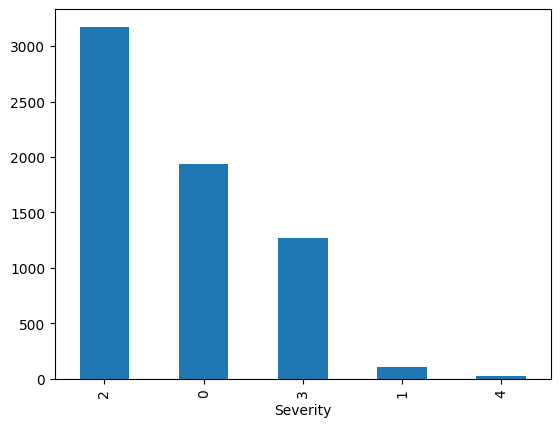

In [ ]:
df_all_instances_MA['Severity'].value_counts().plot(kind='bar')

<Axes: xlabel='Crash'>

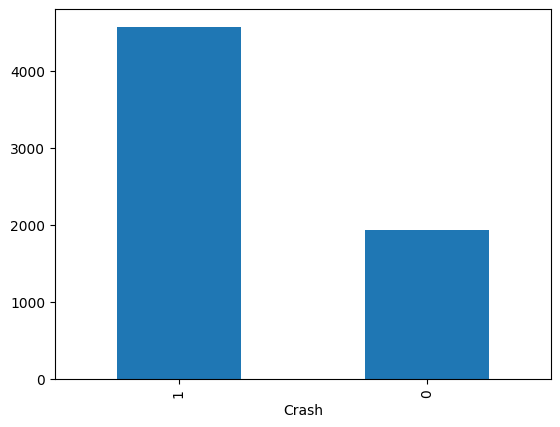

In [ ]:
df_all_instances_MA['Crash'].value_counts().plot(kind='bar')

<Axes: xlabel='Start_Time'>

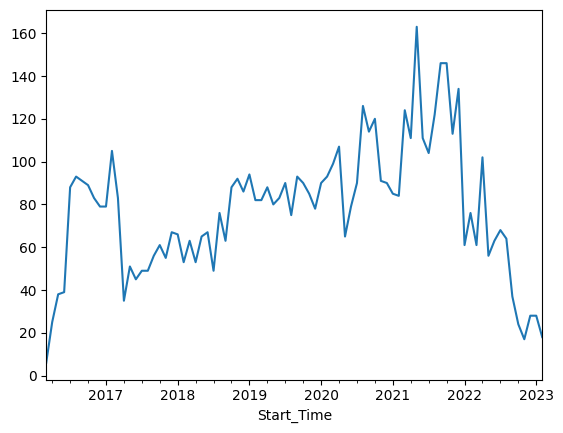

In [ ]:
df_all_instances_MA['Start_Time'] = pd.to_datetime(df_all_instances_MA['Start_Time'])
df_all_instances_MA.set_index('Start_Time', inplace=True)
df_all_instances_MA.resample('M').size().plot()

In [ ]:
import folium
from folium.plugins import HeatMap

m = folium.Map(location=[42.331589, -71.101957], zoom_start=12)
heat_data = [[row['Start_Lat'], row['Start_Lng']] for index, row in df_all_instances_MA.iterrows()]
HeatMap(heat_data).add_to(m)
m.save('heatmap.html')
m

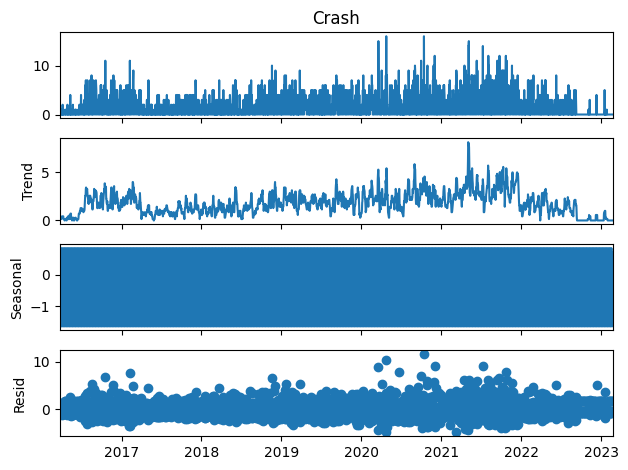

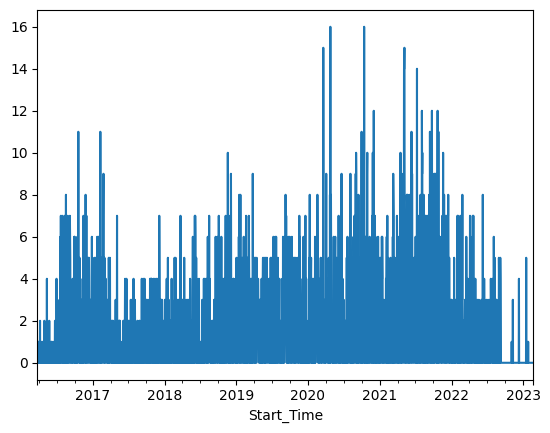

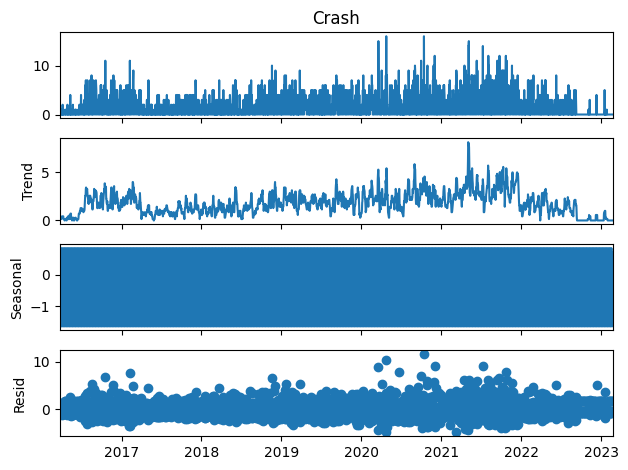

In [ ]:
daily_crashes = df_all_instances_MA['Crash'].resample('D').sum()
daily_crashes.plot()
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(daily_crashes, model='additive')
result.plot()

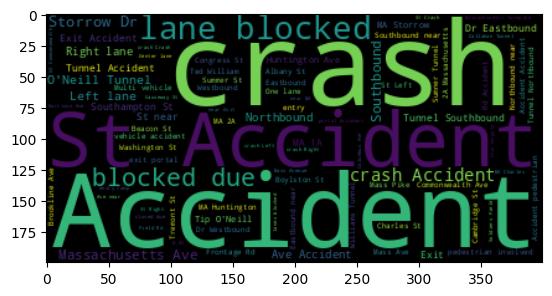

In [ ]:
from wordcloud import WordCloud
text = ' '.join(df_all_instances_MA['Description'])
wordcloud = WordCloud().generate(text)
plt.imshow(wordcloud, interpolation='bilinear')

In [ ]:
import folium
from folium.plugins import MarkerCluster

m = folium.Map(location=[df_all_instances_MA['Start_Lat'].mean(), df_all_instances_MA['Start_Lng'].mean()], zoom_start=10)
mc = MarkerCluster()
for idx, row in df_all_instances_MA.iterrows():
    if row['Crash'] == 1:
        folium.Marker([row['Start_Lat'], row['Start_Lng']]).add_to(mc)
mc.add_to(m)
m.save('cluster_map.html')
m

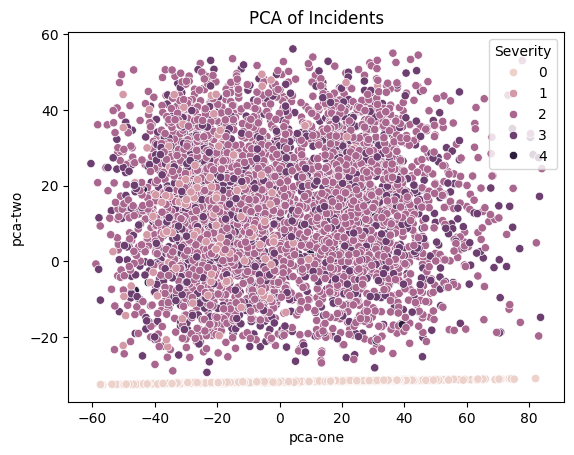

In [ ]:
from sklearn.decomposition import PCA
import seaborn as sns

pca = PCA(n_components=2)
pca_result = pca.fit_transform(df_all_instances_MA.select_dtypes(include=[float, int]))
df_all_instances_MA['pca-one'] = pca_result[:,0]
df_all_instances_MA['pca-two'] = pca_result[:,1]

sns.scatterplot(x='pca-one', y='pca-two', hue='Severity', data=df_all_instances_MA)
plt.title('PCA of Incidents')
plt.show()

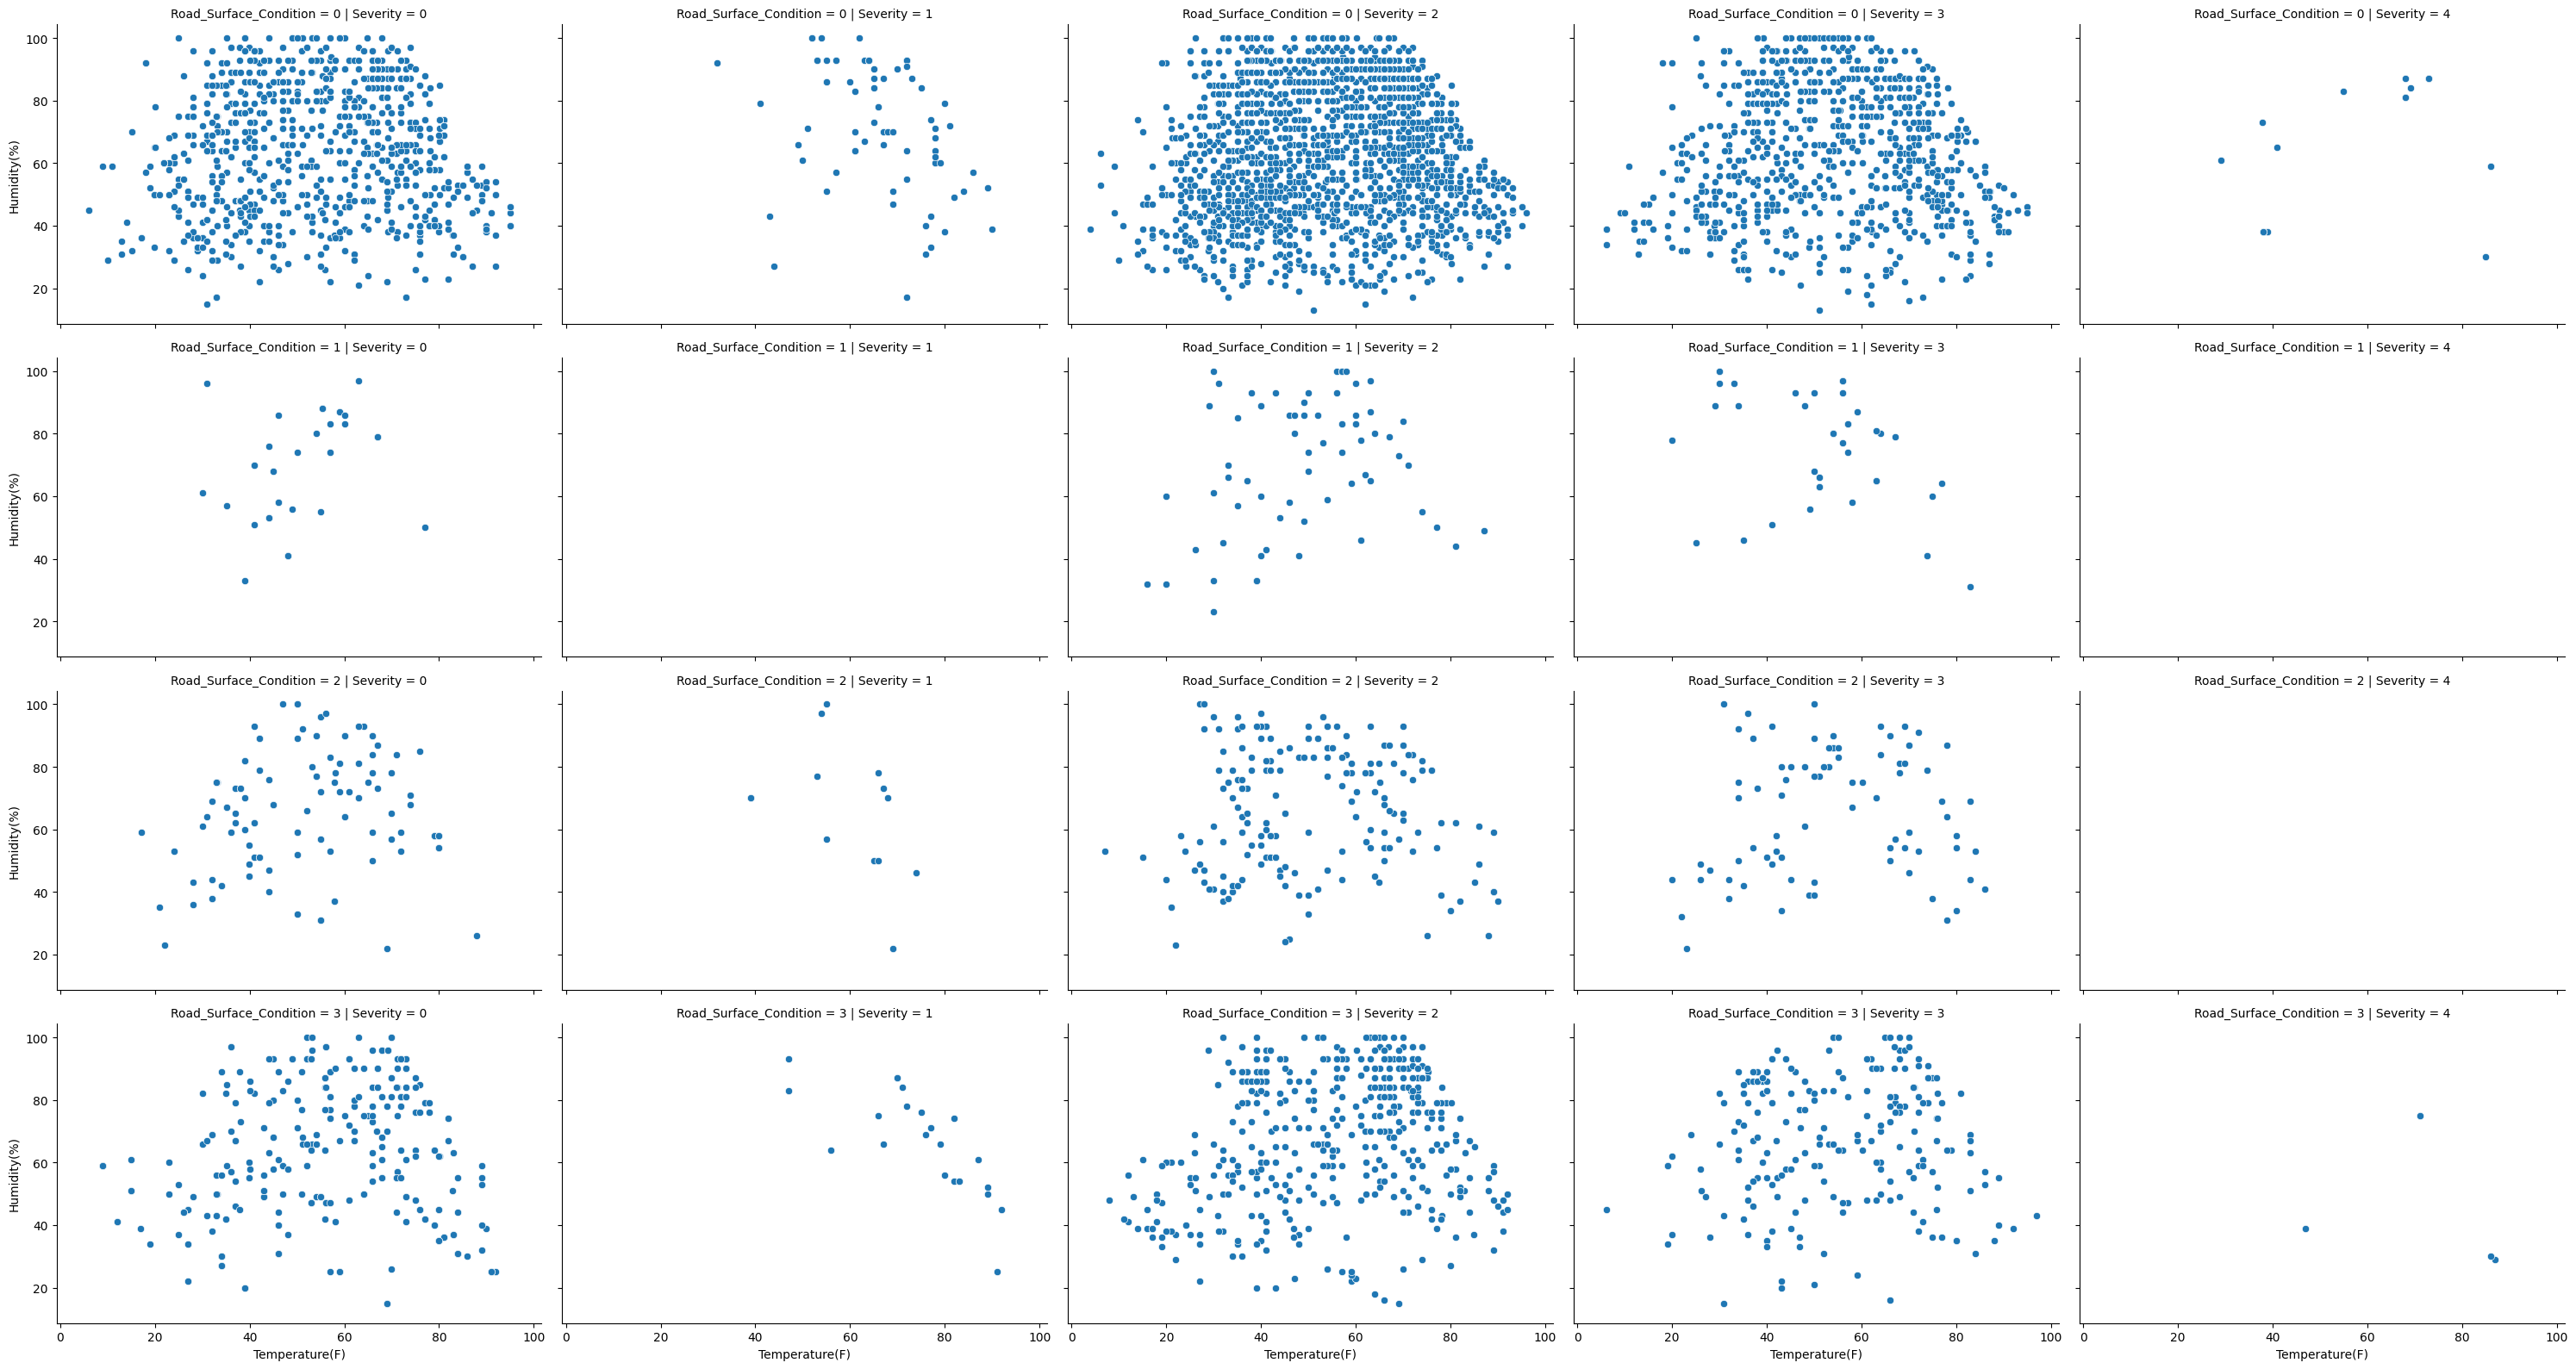

In [ ]:
g = sns.FacetGrid(df_all_instances_MA, col='Severity', row='Road_Surface_Condition', height=4, aspect=1.5)
g.map(sns.scatterplot, 'Temperature(F)', 'Humidity(%)')
plt.show()

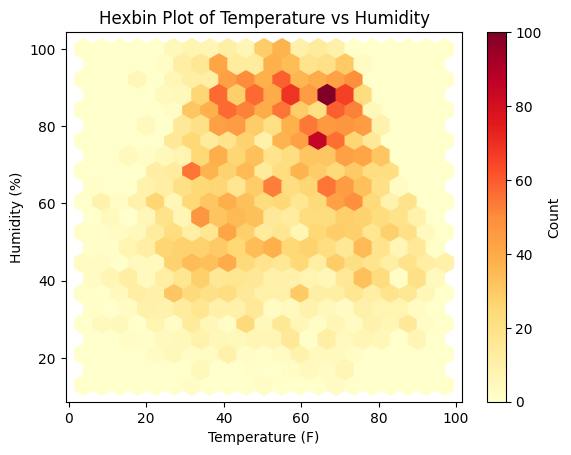

In [ ]:
plt.hexbin(df_all_instances_MA['Temperature(F)'], df_all_instances_MA['Humidity(%)'], gridsize=20, cmap='YlOrRd')
plt.colorbar(label='Count')
plt.xlabel('Temperature (F)')
plt.ylabel('Humidity (%)')
plt.title('Hexbin Plot of Temperature vs Humidity')
plt.show()

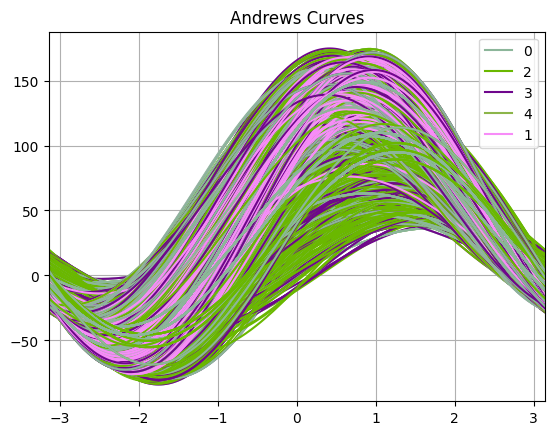

In [ ]:
from pandas.plotting import andrews_curves

andrews_curves(df_all_instances_MA[['Temperature(F)', 'Humidity(%)', 'Wind_Chill(F)', 'Severity']], 'Severity')
plt.title('Andrews Curves')
plt.show()

In [ ]:
import plotly.graph_objects as go

# Define the node colors
node_colors = ['blue', 'orange', 'green', 'yellow']  # Bright colors for the nodes

fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=["Severity 1", "Severity 2", "Dry", "Wet", "Icy"],
        color=node_colors  # Use the updated colors here
    ),
    link=dict(
        source=[0, 0, 1, 1],  # Indices of the source nodes
        target=[2, 3, 3, 4],  # Indices of the target nodes
        value=[8, 4, 2, 8]    # Values for the links
    )
)])

fig.update_layout(title_text="Sankey Diagram of Severity and Road Conditions", font_size=10)
fig.show()

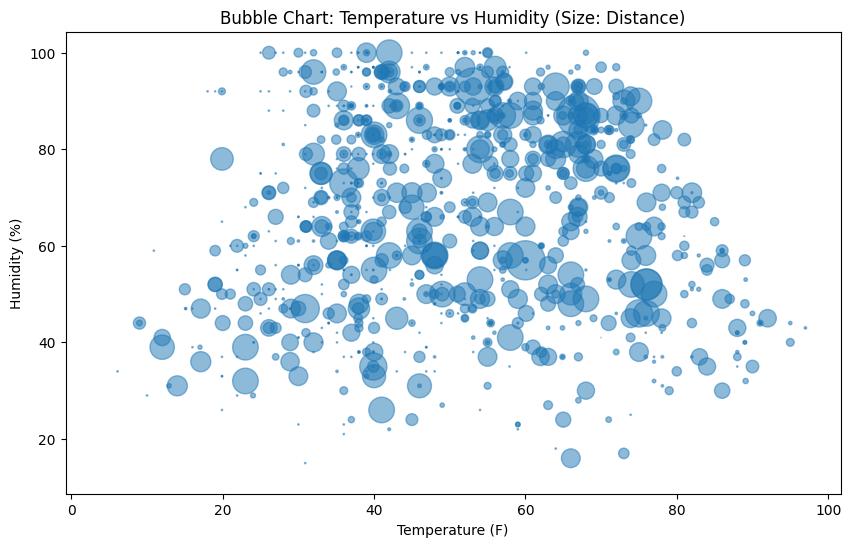

In [ ]:
plt.figure(figsize=(10,6))
plt.scatter(df_all_instances_MA['Temperature(F)'], df_all_instances_MA['Humidity(%)'], s=df_all_instances_MA['Distance(mi)']*100, alpha=0.5)
plt.xlabel('Temperature (F)')
plt.ylabel('Humidity (%)')
plt.title('Bubble Chart: Temperature vs Humidity (Size: Distance)')
plt.show()

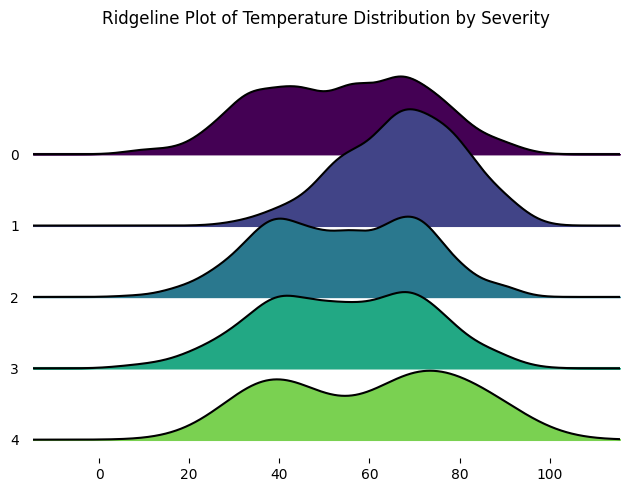

In [ ]:
!pip install joypy
import joypy

fig, axes = joypy.joyplot(df_all_instances_MA, by="Severity", column="Temperature(F)", colormap=plt.cm.viridis)
plt.title('Ridgeline Plot of Temperature Distribution by Severity')
plt.show()

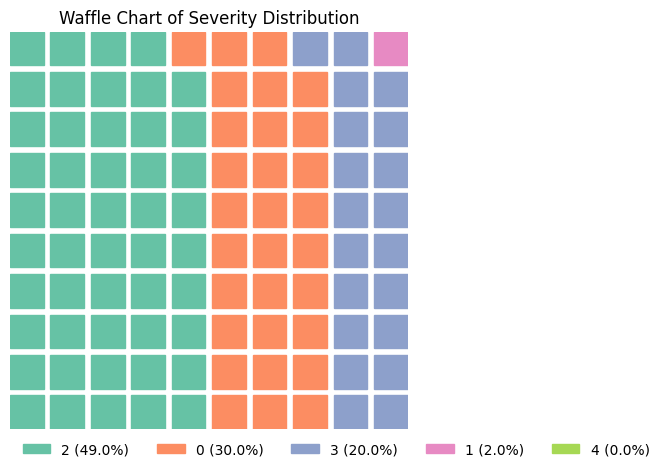

In [ ]:
from pywaffle import Waffle

data = dict(df_all_instances_MA['Severity'].value_counts(normalize=True).round(2) * 100)

fig = plt.figure(
    FigureClass=Waffle,
    rows=10,
    columns=10,
    values=data,
    title={'label': 'Waffle Chart of Severity Distribution', 'loc': 'center'},
    labels=[f"{k} ({v}%)" for k, v in data.items()],
    legend={'loc': 'lower left', 'bbox_to_anchor': (0, -0.1), 'ncol': len(data), 'framealpha': 0}
)
plt.show()